In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
from tqdm import tqdm

sys.path.append('../lib')
from storage import get_storage_functions, quantize
from local_paths import preproc_dir, analysis_dir
from self_consistency import \
    find_return_fixations, pairwise_self_consistency

# Set parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# response windows
#============================================================================
t_pre  = 200
t_post = 375
t_step =  10


#============================================================================
# return fixation selection
#============================================================================
return_thres = 1  # for defining "return fixation"; can set to typical radius of rf


#============================================================================
# other miscellaneous
#============================================================================
n_boots = 200


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir
sdf_dir = preproc_dir
sdf_suffix = '-mwa_50'

output_dir = analysis_dir + 'fix0_self_consistency'


#============================================================================
# misc
#============================================================================
n_jobs = 1  # for numba; <= 1: fractional; > 1: integer

In [3]:
# Parameters
sess_name = "Pa210201"
sdf_suffix = "-mwa_50-hg"
output_dir = "../test_results/hier_group"


# Check prerequisite and whether already done

In [4]:
proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

preproc_main_path = Path(preproc_dir) / (sess_name + '-main.nwb')
preproc_events_path = Path(preproc_dir) / (sess_name + '-events.h5')
print('Loading preprocessed data from:')
print('\tmain:\t', preproc_main_path)
print('\tevents:\t', preproc_events_path)
preproc_main_path = preproc_main_path.expanduser()
preproc_events_path = preproc_events_path.expanduser()
assert preproc_main_path.is_file()
assert preproc_events_path.is_file()

sdf_path = Path(sdf_dir) / (sess_name + f'-sdf{sdf_suffix}.h5')
print('Loading spike density function from', sdf_path)
sdf_path = sdf_path.expanduser()
assert sdf_path.is_file()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading shared processing from ../test_data/Pa210201-proc.h5
Loading preprocessed data from:
	main:	 ../test_data/Pa210201-main.nwb
	events:	 ../test_data/Pa210201-events.h5
Loading spike density function from ../test_data/Pa210201-sdf-mwa_50-hg.h5
Saving results to ../test_results/hier_group/Pa210201.h5


In [5]:
analysis_name = 'fix0_self_consistency'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

# Prepare parameters; save config

In [6]:
with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]
    fix_sel = f['fixation_selection/fixation_indices'][()]
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')

print('random_seed:', random_seed)

random_seed: 775418045


In [7]:
m = 0 == fix_df.index.get_level_values(fix_df.index.names.index('Fixation'))[fix_sel]
print(f'from {m.size} fixations, selecting {m.sum()} ({m.mean()*100:.1f}%) zeroth-fixations')
fix_sel = fix_sel[m]

from 5979 fixations, selecting 1279 (21.4%) zeroth-fixations


In [8]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [9]:
group = analysis_name + '/config/'
save_results(group+'random_seed', random_seed)
save_results(group+'sdf_suffix', sdf_suffix)

group = analysis_name + '/config/time_windows/'
save_results(group+'t_pre', t_pre)
save_results(group+'t_post', t_post)
save_results(group+'t_step', t_step)
add_attr_to_dset(group, attrs=dict(unit='ms'))

group = analysis_name + '/config/return_criterion/'
save_results(group+'return_thres', return_thres, attrs=dict(unit='dva'))

# Exclude trials showing fixation point unless all did

Rationale: If only a subset of trials showed fixation, it may be spuriously correlated with image identity, leading to self-consistency in the fixation-point responses, thus resulting in incorrect (early) latency. If all trials showed the fixation point, there would be no spurious correlation. (Self-consistency depends on differential responses to images.)

In [10]:
with h5.File(preproc_main_path, 'r') as f:
    trial_ids = f['intervals/trials/id'][()]
    trial_t0s = f['intervals/trials/start_time'][()]
    trial_t1s = f['intervals/trials/stop_time'][()]

with h5.File(preproc_events_path, 'r') as f:
    event_ts = f['events/times'][()]
    event_vs = f['events/words'][()]

trial_df = pd.DataFrame({
    'Trial': trial_ids,
    'Start time': trial_t0s * 1e3,
    'End time': trial_t1s * 1e3,
}).set_index('Trial')

In [11]:
fix_itrs = fix_df.index.get_level_values(fix_df.index.names.index('Trial'))
uitrs = fix_itrs.unique().values
uitrs_excl_mask = np.zeros_like(uitrs, dtype=bool)

# the follow code is specific to which & when digital event words were sent by the task implementation
fix_on_code = 5
fix_off_code = 6
t_tol = 5

i0 = 0
for iitr, itr in enumerate(tqdm(uitrs)):
    # add some slack to mae sure word is not missed
    tt0, tt1 = trial_df.loc[itr, ['Start time', 'End time']] + [-50, 50]
    st0 = fix_df.loc[(itr, slice(None)),]['Time'].max() + 50

    # find relevant word indices
    it0 = np.searchsorted(event_ts[i0:], tt0) + i0
    is0 = np.searchsorted(event_ts[it0:], st0) + it0
    it1 = np.searchsorted(event_ts[is0:], tt1) + is0

    # clip off trial header if any
    for i, w in enumerate(event_vs[it0:it1]):
        if w == 3 and \
                np.array_equal(event_vs[it0+i:it0+i+5], [3, 2, 1, 255, 255]):
            it0 = it0 + i + 5

    # exclude any trial containing fix on or off event(s)
    for name, code in (('fix_on', fix_on_code), ('fix_off', fix_off_code)):
        match = event_vs[it0:it1] == fix_on_code
        count = match.sum()
        # validate integrity; exclude any suspicious trials
        if count > 1:
            # sometimes one event can be multiply stamped
            # check for this by the spread in timing
            spread = event_ts[it0:it1][match].ptp()
            if spread <= t_tol:
                print(
                    f'Cannot infer {name} time for trial {itr}! Found '
                    'more than one corresponding event '
                    f'(count = {count}, spread = {spread:.3f} ms)')
                uitrs_excl_mask[iitr] = True

        if count > 0:
            uitrs_excl_mask[iitr] = True

    i0 = it1

100%|█████████████████████████████████████| 1911/1911 [00:01<00:00, 1228.05it/s]

In [12]:
m = uitrs_excl_mask
if m.all():
    print(f'all trials ({m.sum()}) showeed a fixation point')
else:
    print(f'excluding {m.sum()} trials ({m.mean()*100:.1f}%) that may have shown a fixation point before image onset')
    fix_excl_idc = np.nonzero(fix_itrs.isin(uitrs[uitrs_excl_mask]))[0]
    m = ~pd.Series(fix_sel).isin(fix_excl_idc)
    print(f'from {m.size} zeroth fixations, selecting {m.sum()} ({m.mean()*100:.1f}%) that did not involve a fixation point in the trial')
    fix_sel = fix_sel[m]

excluding 93 trials (4.9%) that may have shown a fixation point before image onset
from 1279 zeroth fixations, selecting 1190 (93.0%) that did not involve a fixation point in the trial


In [13]:
save_results(analysis_name+'/fixation_selection', fix_sel)

# Find return pairs

In [14]:
df_ = fix_df.iloc[fix_sel]
imids = np.array([f'{v0}/{v1}' for v0, v1 in df_[['Image subdir', 'Image filename']].values])
posns = df_[['Relative X', 'Relative Y']].values

return_pairs = find_return_fixations(imids, posns, thres_deg=return_thres)
same_im_pairs = find_return_fixations(imids, np.zeros_like(posns), thres_deg=return_thres)

print('Return fixations pairs shape:', return_pairs.shape)
print('Same image pairs shape:', same_im_pairs.shape)

bycond_return_pairs = dict(
    return_fixation=return_pairs,
    same_image=same_im_pairs)

Return fixations pairs shape: (17, 2)
Same image pairs shape: (607, 2)


In [15]:
group = analysis_name + '/return_pairs/'
for cond, pairs in bycond_return_pairs.items():
    if not pairs.size:
        pairs = h5.Empty('i')
    save_results(group+cond, pairs)

# Get stimulus onset-aligned responses

In [16]:
with h5.File(sdf_path, 'r') as f:
    dset = f['sdf']
    unit_names = dset.attrs['unit_names'].astype(str)
    sdf = dset[()]
    if 'unit_names' in f:
        copy_group(f, 'unit_names', analysis_name+'/unit_names')

n_neur = sdf.shape[1]
unit_names.shape, unit_names.dtype, sdf.shape, sdf.dtype

((106,), dtype('<U10'), (6234150, 106), dtype('float32'))

In [17]:
ts = np.arange(-t_pre, t_post, t_step)

resps = np.empty_like(sdf, shape=(fix_sel.size, ts.size, sdf.shape[-1]))
for i, t in enumerate(fix_df.iloc[fix_sel]['Time'].values):
    ts_ = np.round(t+ts).astype(int)
    resps[i] = sdf[ts_,:]

resps.shape, resps.dtype

((1190, 58, 106), dtype('float32'))

# Calculate self-consistency

In [18]:
coords = (('time', ts), ('unit', unit_names))
attrs = dict(
    return_thres=return_thres,
    random_seed=random_seed,
    unit="Pearson's r"
)

bycond_rsc_ds = {}
for cond, pairs in bycond_return_pairs.items():
    if len(pairs) > 1:
        attrs['n_pairs'] = len(pairs)
        ds = pairwise_self_consistency(
            pairs=pairs, resps=resps,
            n_bootstraps=n_boots, n_permutations=0,
            random_seed=random_seed,
            coords=coords, attrs=attrs)
    else:
        ds = None
    bycond_rsc_ds[cond] = ds

In [19]:
group = analysis_name + '/'
q = lambda x: quantize(x, 3)
compr = dict(zlib=True, complevel=9)
for cond, dataset in bycond_rsc_ds.items():
    loc = group + cond
    if dataset is not None:
        dataset = dataset.assign({
            k: q(v)
            for k, v in dataset.data_vars.items()})
        encoding = {
            k: dict(chunksizes=v.shape, **compr)
            for k, v in dataset.data_vars.items()
            if v.size}
        dataset.to_netcdf(
            output_path, group=loc, mode='a',
            engine='h5netcdf', encoding=encoding)
    else:
        save_results(loc, h5.Empty('f'))

# Wrap up

In [20]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [21]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-19T22:04:59.284046-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

h5py  : 3.8.0
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
pandas: 2.0.1
numpy : 1.24.3



# Basic visualization of results

In [22]:
import matplotlib.pyplot as plt

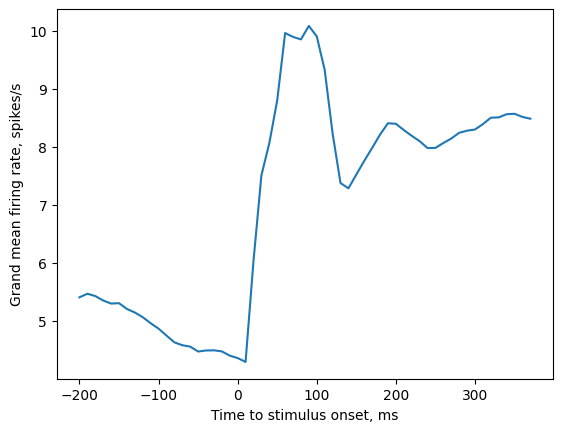

In [23]:
plt.plot(ts, resps.mean((0,2)))
plt.xlabel('Time to stimulus onset, ms')
plt.ylabel('Grand mean firing rate, spikes/s');

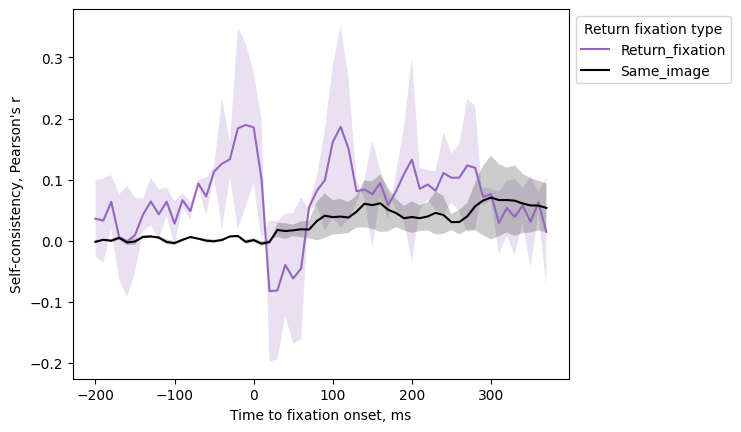

In [24]:
if any(v is not None for v in bycond_rsc_ds.values()):
    for k, color in (
            ('return_fixation', 'tab:purple'),
            ('same_image', 'k'),
    ):
        value = bycond_rsc_ds[k]
        if value is None: continue
        val = value['sample'].values
        m = np.nanmean(val, -1)
        s = np.nanmedian(val, -1)
        l, = plt.plot(ts, m, label=k.capitalize(), color=color)
        plt.fill_between(ts, m-s, m+s, ec='none', fc=l.get_color(), alpha=0.2)
    plt.xlabel('Time to fixation onset, ms')
    plt.ylabel('Self-consistency, Pearson\'s r')
    plt.legend(title='Return fixation type', loc='upper left', bbox_to_anchor=(1,1))